In [281]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import t
from scipy.special import stdtr
from numpy.random import seed
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
import numpy as np
from sklearn.preprocessing import LabelEncoder


In [190]:
df_combat = pd.read_csv(r"data_center/combats.csv")
df_combat.info()
df_combat.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   First_pokemon   50000 non-null  int64
 1   Second_pokemon  50000 non-null  int64
 2   Winner          50000 non-null  int64
dtypes: int64(3)
memory usage: 1.1 MB


,First_pokemon,Second_pokemon,Winner
0,266,298,298
1,702,701,701
2,191,668,668
3,237,683,683
4,151,231,151


In [191]:
df_pokemon = pd.read_csv(r"data_center/pokemon.csv")
df_pokemon.info()
df_pokemon.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   #           800 non-null    int64 
 1   Name        799 non-null    object
 2   Type 1      800 non-null    object
 3   Type 2      414 non-null    object
 4   HP          800 non-null    int64 
 5   Attack      800 non-null    int64 
 6   Defense     800 non-null    int64 
 7   Sp. Atk     800 non-null    int64 
 8   Sp. Def     800 non-null    int64 
 9   Speed       800 non-null    int64 
 10  Generation  800 non-null    int64 
 11  Legendary   800 non-null    bool  
dtypes: bool(1), int64(8), object(3)
memory usage: 69.7+ KB


,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False
4,5,Charmander,Fire,NaN,39,52,43,60,50,65,1,False


In [192]:
# Renommer la colonne '#' en 'id' pour correspondre à l'identifiant des Pokémon
df_pokemon = df_pokemon.rename(columns={'#': 'id'})
# Vérifier le pokemon manquant
print(df_pokemon[df_pokemon['Name'].isnull()])
# Remplacer le nom du Pokémon avec l'id 63 par 'Primeape'
df_pokemon.loc[df_pokemon['id'] == 63, 'Name'] = 'Primeape'

    id Name    Type 1 Type 2  HP  Attack  Defense  Sp. Atk  Sp. Def  Speed  \
62  63  NaN  Fighting    NaN  65     105       60       60       70     95   

    Generation  Legendary  
62           1      False  


In [193]:
#remplacer les valeurs manquantes dans la colonne 'Type 2' par 'None'
df_pokemon['Type 2'] = df_pokemon['Type 2'].fillna('None')
df_pokemon.info()
print(df_pokemon.head())
df_pokemon.isnull().sum()
#DataFrame propre

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          800 non-null    int64 
 1   Name        800 non-null    object
 2   Type 1      800 non-null    object
 3   Type 2      800 non-null    object
 4   HP          800 non-null    int64 
 5   Attack      800 non-null    int64 
 6   Defense     800 non-null    int64 
 7   Sp. Atk     800 non-null    int64 
 8   Sp. Def     800 non-null    int64 
 9   Speed       800 non-null    int64 
 10  Generation  800 non-null    int64 
 11  Legendary   800 non-null    bool  
dtypes: bool(1), int64(8), object(3)
memory usage: 69.7+ KB
   id           Name Type 1  Type 2  HP  Attack  Defense  Sp. Atk  Sp. Def  \
0   1      Bulbasaur  Grass  Poison  45      49       49       65       65   
1   2        Ivysaur  Grass  Poison  60      62       63       80       80   
2   3       Venusaur  Grass  Poison  80  

id            0
Name          0
Type 1        0
Type 2        0
HP            0
Attack        0
Defense       0
Sp. Atk       0
Sp. Def       0
Speed         0
Generation    0
Legendary     0
dtype: int64

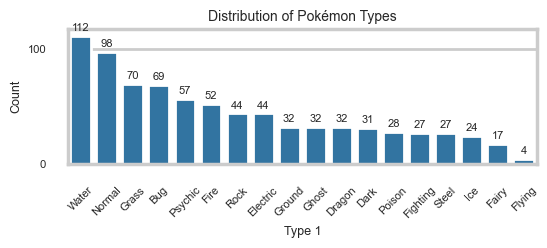

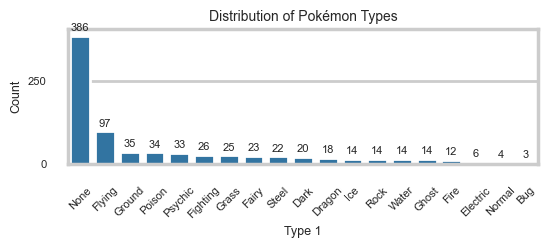

In [194]:
plt.figure(figsize=(6, 3))
ax = sns.countplot(data=df_pokemon, x='Type 1', order=df_pokemon['Type 1'].value_counts().index)
for container in ax.containers:
    ax.bar_label(container, fontsize=8, padding=2)

plt.xticks(rotation=45, fontsize=8)
plt.yticks(fontsize=8)
plt.title('Distribution of Pokémon Types', fontsize=10)
plt.xlabel('Type 1', fontsize=9)
plt.ylabel('Count', fontsize=9)

plt.tight_layout()

plt.figure(figsize=(6, 3))
ax = sns.countplot(data=df_pokemon, x='Type 2', order=df_pokemon['Type 2'].value_counts().index)
for container in ax.containers:
    ax.bar_label(container, fontsize=8, padding=2)

plt.xticks(rotation=45, fontsize=8)
plt.yticks(fontsize=8)
plt.title('Distribution of Pokémon Types', fontsize=10)
plt.xlabel('Type 1', fontsize=9)
plt.ylabel('Count', fontsize=9)

plt.tight_layout()
plt.show()

In [195]:
#preparation des données pour l'analyse des forces des types de pokemon
df_filtered = df_pokemon.drop(columns=['id', 'Generation', 'Legendary'])
# Agregation des statistiques en total
stats_cols = ['Attack', 'Defense', 'HP', 'Sp. Atk', 'Sp. Def', 'Speed']
df_filtered['Total'] = df_filtered[stats_cols].sum(axis=1)
# Calcul de la moyenne des statistiques par type de Pokémon
grouped = df_filtered.groupby('Type 1').mean(numeric_only=True).sort_values(by="Total",ascending=False)

C:\Users\alexa\AppData\Local\Temp\ipykernel_14388\952481030.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=grouped.index, y='Total', data=grouped, palette='pastel')


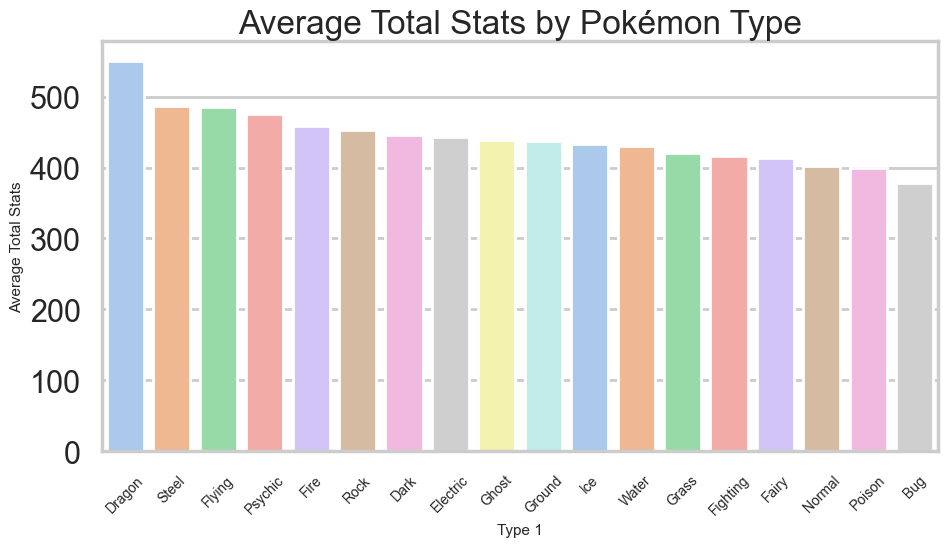

In [196]:
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=grouped.index, y='Total', data=grouped, palette='pastel')
ax.set_title('Average Total Stats by Pokémon Type')
ax.set_xlabel('Type 1', fontsize=11)
ax.set_ylabel('Average Total Stats', fontsize=11)
plt.xticks(rotation=45, fontsize=10)
plt.tight_layout()
plt.show()

Cela donne une idée assez précise de la puissance moyenne des pokemon avec Dragon en tête et insecte en fin de liste

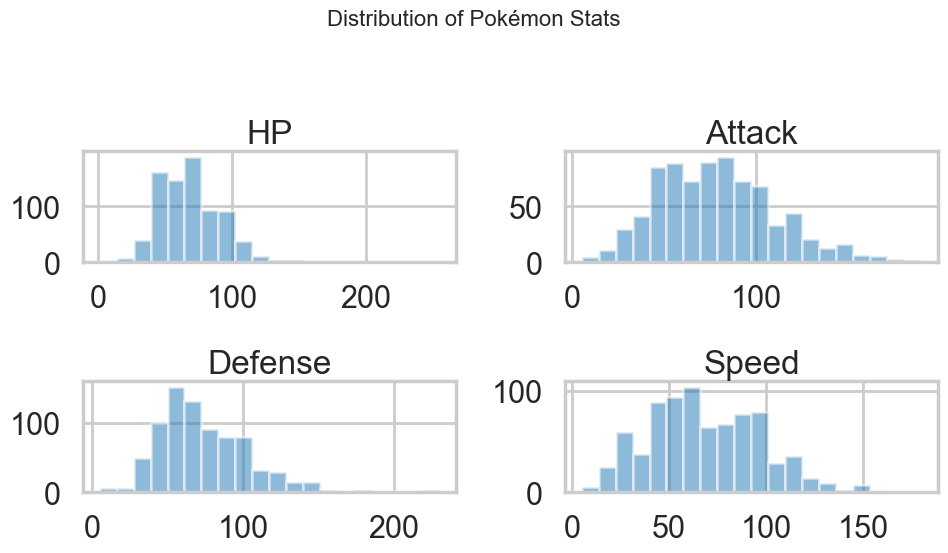

In [197]:

df_filtered[['HP', 'Attack', 'Defense','Speed']].hist(bins=20, alpha=0.5, figsize=(10, 6))
plt.suptitle('Distribution of Pokémon Stats', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()  

Text(0.5, 0, 'Stat Value')

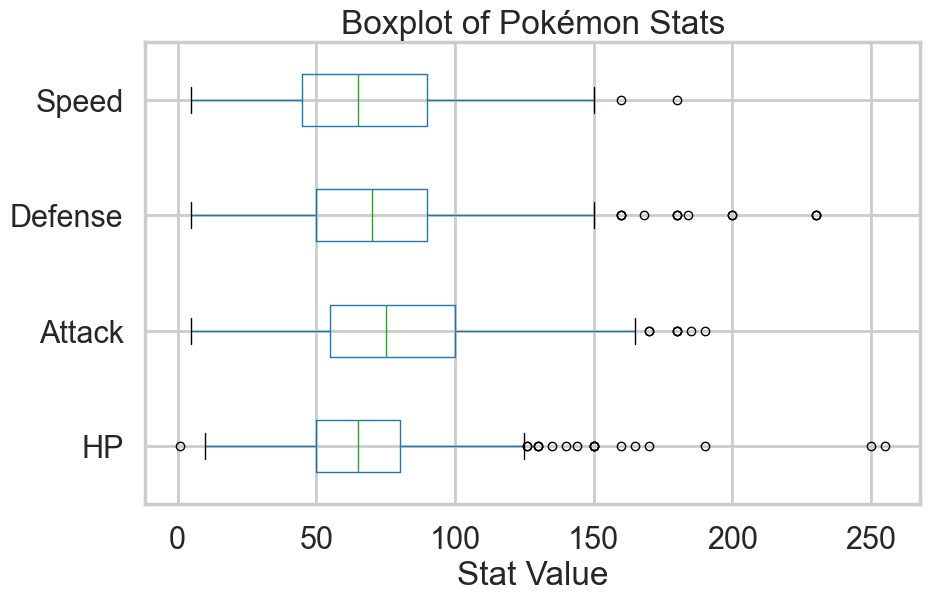

In [198]:
df_filtered[['HP', 'Attack', 'Defense','Speed']].boxplot(figsize=(10, 6), vert=False)
plt.title('Boxplot of Pokémon Stats')
plt.xlabel('Stat Value')    

Quelques extreme mais rien d'abherant

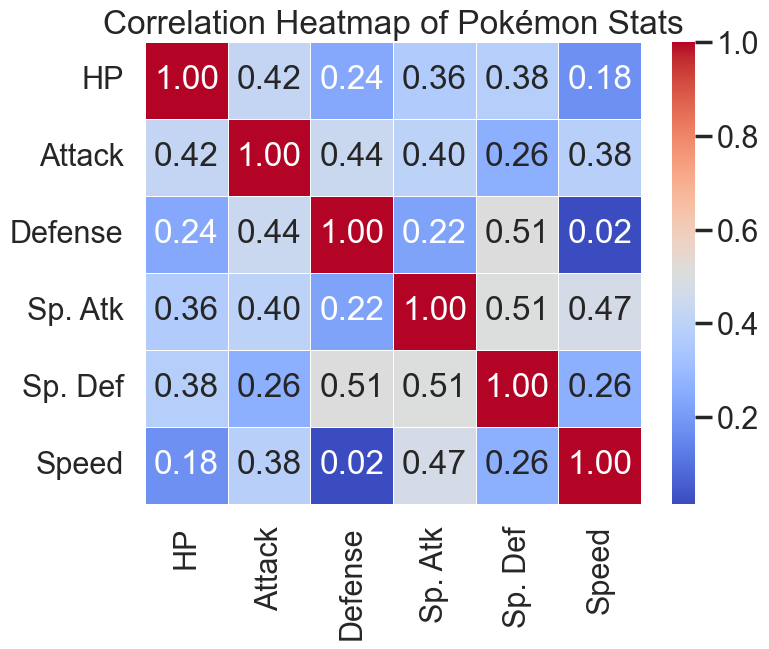

In [199]:
heatmap_data = df_filtered[['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Pokémon Stats')
plt.show()

In [219]:
# Étape 1 : Compter les victoires
win_counts = df_combat['Winner'].value_counts()

# Étape 2 : Compter les combats totaux pour chaque Pokémon (présent en First OU Second)
first_counts = df_combat['First_pokemon'].value_counts()
second_counts = df_combat['Second_pokemon'].value_counts()
total_counts = first_counts.add(second_counts, fill_value=0)

# Étape 3 : Créer le DataFrame avec les résultats
win_rate_df = pd.DataFrame({
    'Wins': win_counts,
    'Total Battles': total_counts
})

# Remplacer les NaN (pour ceux qui n'ont jamais gagné) par 0
win_rate_df['Wins'] = win_rate_df['Wins'].fillna(0).astype(int)
win_rate_df['Total Battles'] = win_rate_df['Total Battles'].fillna(0).astype(int)

# Étape 4 : Calcul du taux de victoire (arrondi à 2 décimales)
win_rate_df['Win Percentage %'] = (win_rate_df['Wins'] / win_rate_df['Total Battles'] * 100).round(2)

# Trier par taux de victoire décroissant
win_rate_df = win_rate_df.sort_values(by='Win Percentage %', ascending=False)

# Résultat
print(win_rate_df.head(10))

     Wins  Total Battles  Win Percentage %
155   127            129             98.45
513   116            119             97.48
704   121            125             96.80
20    115            119             96.64
154   136            141             96.45
477   124            129             96.12
727   122            127             96.06
717   118            123             95.93
165   119            125             95.20
350   114            120             95.00


In [220]:
df_merge = pd.merge(win_rate_df, df_pokemon, left_index=True, right_on='id', how='left')
df_merge.reset_index(drop=True, inplace=True)

df_merge.head(10)

,Wins,Total Battles,Win Percentage %,id,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,127,129,98.45,155,Mega Aerodactyl,Rock,Flying,80,135,85,70,95,150,1,False
1,116,119,97.48,513,Weavile,Dark,Ice,70,120,65,45,85,125,4,False
2,121,125,96.80,704,Tornadus Therian Forme,Flying,None,79,100,80,110,90,121,5,True
3,115,119,96.64,20,Mega Beedrill,Bug,Poison,65,150,40,15,80,145,1,False
4,136,141,96.45,154,Aerodactyl,Rock,Flying,80,105,65,60,75,130,1,False
5,124,129,96.12,477,Mega Lopunny,Normal,Fighting,65,136,94,54,96,135,4,False
6,122,127,96.06,727,Greninja,Water,Dark,72,95,67,103,71,122,6,False
7,118,123,95.93,717,Meloetta Pirouette Forme,Normal,Fighting,100,128,90,77,77,128,5,False
8,119,125,95.20,165,Mega Mewtwo Y,Psychic,None,106,150,70,194,120,140,1,True
9,114,120,95.00,350,Mega Sharpedo,Water,Dark,70,140,70,110,65,105,3,False


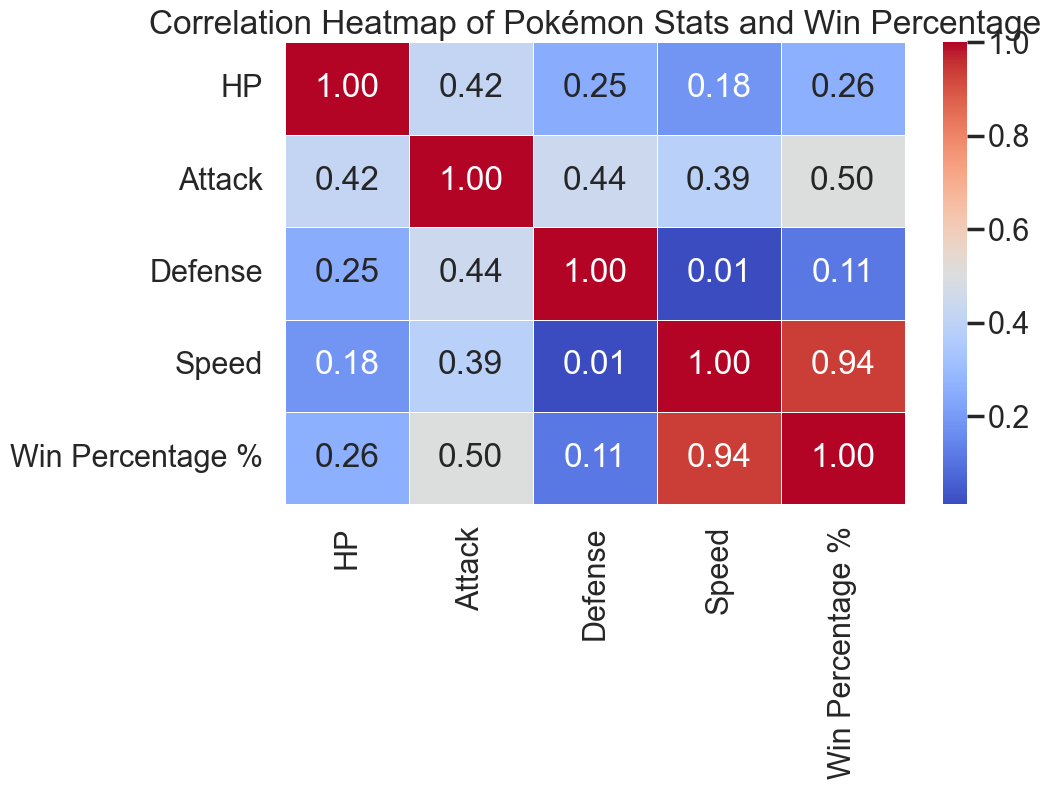

In [221]:
# Create a correlation matrix to identify relationships between stats (HP, Attack, Speed) and win percentage.
correlation_matrix = df_merge[['HP', 'Attack', 'Defense', 'Speed', 'Win Percentage %']].corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Pokémon Stats and Win Percentage')
plt.show()   

On voit que la vitesse est très correllé au taux de victoire (tout comme l'attaque)
Les HP et la défense beaucoup moins.

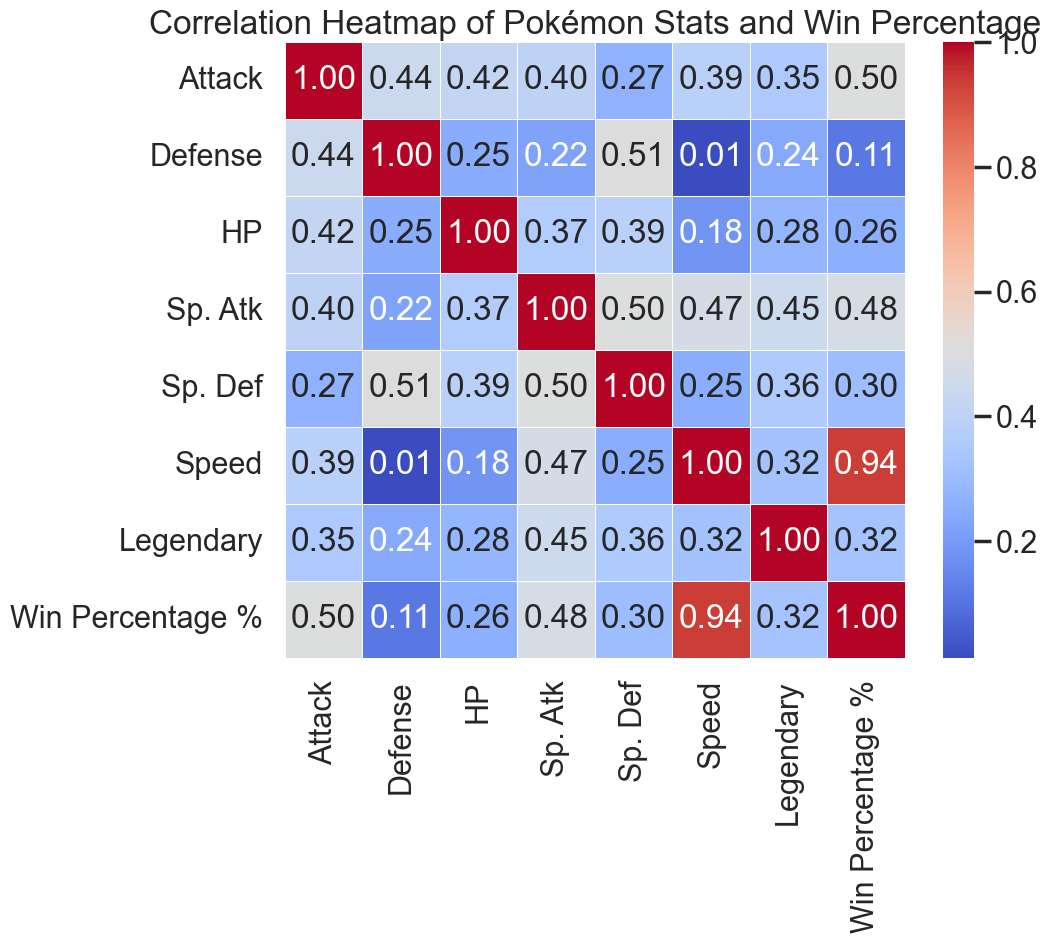

In [222]:
correlation_matrix_all = df_merge[['Attack', 'Defense', 'HP', 'Sp. Atk', 'Sp. Def', 'Speed', 'Legendary', 'Win Percentage %']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix_all, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Pokémon Stats and Win Percentage')
plt.show()

En verifiant les autres valeurs on observe de Speed, Att, Sp.Att et Legendary sont les plus importante valeur pour le taux de victoire.
Coherent avec Mega Aerodactyl (number1)

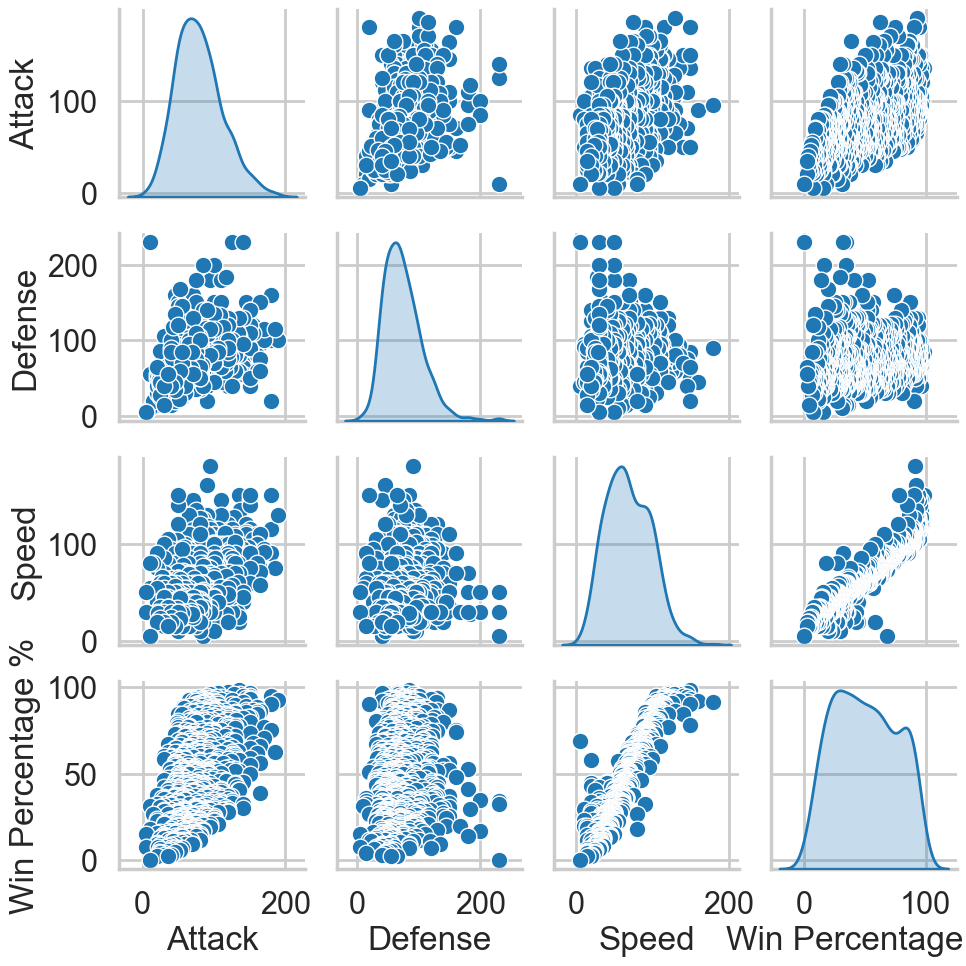

In [223]:
sns.pairplot(df_merge[['Attack', 'Defense','Speed', 'Win Percentage %']], diag_kind='kde')    

plt.show()  


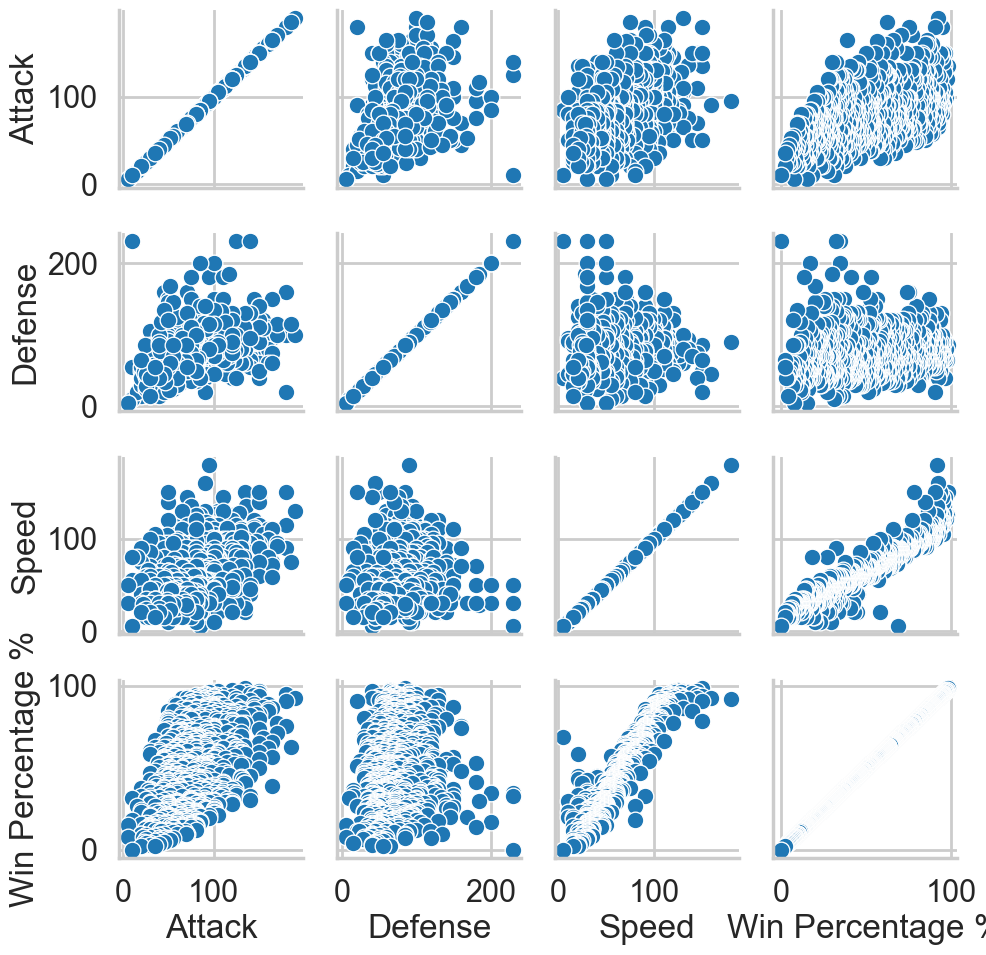

In [224]:
sns.PairGrid(df_merge, vars=['Attack', 'Defense', 'Speed', 'Win Percentage %']).map(sns.scatterplot)
plt.show()

On observe bien sur la vitesse une grosse correlation, l'attaque aussi mais quand même moins.

In [233]:
df_merge.describe()

,Wins,Total Battles,Win Percentage %,id,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation
count,784.000000,784.000000,784.000000,784.000000,784.000000,784.000000,784.000000,784.000000,784.000000,784.000000,784.000000
mean,63.775510,127.551020,50.089821,402.654337,69.077806,78.919643,73.899235,72.758929,71.951531,68.362245,3.338010
std,32.983848,11.393236,25.545758,230.232187,25.393311,32.575170,31.360815,32.729033,27.811906,29.227411,1.656069
min,0.000000,92.000000,0.000000,1.000000,1.000000,5.000000,5.000000,10.000000,20.000000,5.000000,1.000000
25%,36.000000,120.000000,28.372500,204.750000,50.000000,55.000000,50.000000,50.000000,50.000000,45.000000,2.000000
50%,61.500000,128.000000,49.090000,402.500000,65.000000,75.000000,70.000000,65.000000,70.000000,65.000000,3.000000
75%,91.000000,135.000000,71.737500,601.250000,80.000000,100.000000,90.000000,95.000000,90.000000,90.000000,5.000000
max,152.000000,164.000000,98.450000,800.000000,255.000000,190.000000,230.000000,194.000000,230.000000,180.000000,6.000000


In [216]:
df_merge.head(10)

,Wins,Total Battles,Win Percentage %,id,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,127,129,98.45,155,Mega Aerodactyl,Rock,Flying,80,135,85,70,95,150,1,False
1,116,119,97.48,513,Weavile,Dark,Ice,70,120,65,45,85,125,4,False
2,121,125,96.80,704,Tornadus Therian Forme,Flying,None,79,100,80,110,90,121,5,True
3,115,119,96.64,20,Mega Beedrill,Bug,Poison,65,150,40,15,80,145,1,False
4,136,141,96.45,154,Aerodactyl,Rock,Flying,80,105,65,60,75,130,1,False
5,124,129,96.12,477,Mega Lopunny,Normal,Fighting,65,136,94,54,96,135,4,False
6,122,127,96.06,727,Greninja,Water,Dark,72,95,67,103,71,122,6,False
7,118,123,95.93,717,Meloetta Pirouette Forme,Normal,Fighting,100,128,90,77,77,128,5,False
8,119,125,95.20,165,Mega Mewtwo Y,Psychic,None,106,150,70,194,120,140,1,True
9,114,120,95.00,350,Mega Sharpedo,Water,Dark,70,140,70,110,65,105,3,False


On observe bien que les 10 meileurs pokemon ont tous une vitesse supérieur à 120
L'attaque va de 150 à 95 ce qui est beacoup pour les Pokemons

In [232]:
df_merge.tail(10)



,Wins,Total Battles,Win Percentage %,id,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
774,7,133,5.26,292,Cascoon,Bug,None,50,35,55,25,25,15,3,False
775,6,125,4.80,210,Wooper,Water,Ground,55,45,45,25,25,15,2,False
776,6,130,4.62,395,Wynaut,Psychic,None,95,23,48,23,48,23,3,False
777,5,115,4.35,189,Igglybuff,Normal,Fairy,90,30,15,40,20,15,2,False
778,5,128,3.91,577,Munna,Psychic,None,76,25,45,67,55,24,5,False
779,4,123,3.25,237,Slugma,Fire,None,40,40,40,70,40,20,2,False
780,4,129,3.10,639,Solosis,Psychic,None,45,30,40,105,50,20,5,False
781,3,122,2.46,190,Togepi,Fairy,None,35,20,65,40,65,20,2,False
782,3,138,2.17,290,Silcoon,Bug,None,50,35,55,25,25,15,3,False
783,0,135,0.00,231,Shuckle,Bug,Rock,20,10,230,10,230,5,2,False


Ici le bon dernier Silcoon a une defence élevé mais sa vitesse n'est que de 5.
Tous les pokemons en queue de liste n'ont pas de vitesse ni d'attaque élevé (moyenne attaque : 78.919643 vitesse moyenne : 68.362245)

# Machine Learning

In [ ]:
X = df_merge[['Attack', 'Defense', 'Speed']]
y = df_merge['Win Percentage %']
le = LabelEncoder()


In [263]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=27)

In [269]:

# Train a Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred = linear_model.predict(X_test)
accuracy_linear = linear_model.score(X_test, y_test)
print(f'Accuracy (Linear Regression): {accuracy_linear:.2f}')
classification_report = linear_model.score(X_test, y_test)



Accuracy (Linear Regression): 0.91


In [ ]:
# Pokemon fort
pokemon_test = pd.DataFrame([[300, 300, 300]], columns=['Attack', 'Defense', 'Speed'])
# 2. Utiliser le modèle pour prédire
predicted_win_percentage = linear_model.predict(pokemon_test)
predicted_clipped = max(0, min(predicted_win_percentage[0], 100))
print(f'Predicted Win Percentage: {predicted_clipped:.2f}%')   

Predicted Win Percentage: 100.00%


In [267]:
# Pokemon Faible
pokemon_test = pd.DataFrame([[30, 30, 30]], columns=['Attack', 'Defense', 'Speed'])
# 2. Utiliser le modèle pour prédire
predicted_win_percentage = linear_model.predict(pokemon_test)
predicted_clipped = max(0, min(predicted_win_percentage[0], 100))
print(f'Predicted Win Percentage: {predicted_clipped:.2f}%')   

Predicted Win Percentage: 13.72%


In [268]:
# Pour le LinearRegression
mae_linear = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error (Linear Regression): {mae_linear:.2f}') 

Mean Absolute Error (Linear Regression): 5.84


Ce qui est plutôt bon pour la valeur retrouver (Autour de 5)

In [294]:
# Train and evaluate a Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=27)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
accuracy_rf = rf_model.score(X_test, y_test)
print(f'Accuracy (Random Forest): {accuracy_rf:.2f}')
print(f'Mean Absolute Error (Random Forest): {mae_rf:.2f}')


Accuracy (Random Forest): 0.94
Mean Absolute Error (Random Forest): 4.42


In [276]:
# Pokemon Faible
pokemon_test = pd.DataFrame([[300, 300, 300]], columns=['Attack', 'Defense', 'Speed'])
# 2. Utiliser le modèle pour prédire
predicted_win_percentage = rf_model.predict(pokemon_test)
predicted_clipped = max(0, min(predicted_win_percentage[0], 100))
print(f'Predicted Win Percentage: {predicted_clipped:.2f}%')   

Predicted Win Percentage: 93.30%


In [295]:
# Train and evaluate a XGBoost
xgb_model = XGBRegressor(n_estimators=100, random_state=27)
xgb_model.fit(X_train, y_train)

# Prédictions
y_pred_xgb = xgb_model.predict(X_test)

# Évaluation
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
accuracy_xgb = xgb_model.score(X_test, y_test)
print(f'Accuracy (XGBoost): {accuracy_xgb:.2f}')
print(f'Mean Absolute Error (XGBoost): {mae_xgb:.2f}')

Accuracy (XGBoost): 0.94
Mean Absolute Error (XGBoost): 4.55


In [ ]:
# Pokemon Faible
pokemon_test = pd.DataFrame([[45, 45, 45]], columns=['Attack', 'Defense', 'Speed'])
# 2. Utiliser le modèle pour prédire
predicted_win_percentage = xgb_model.predict(pokemon_test)
predicted_clipped = max(0, min(predicted_win_percentage[0], 100))
print(f'Predicted Win Percentage: {predicted_clipped:.2f}%')   

Predicted Win Percentage: 22.49%


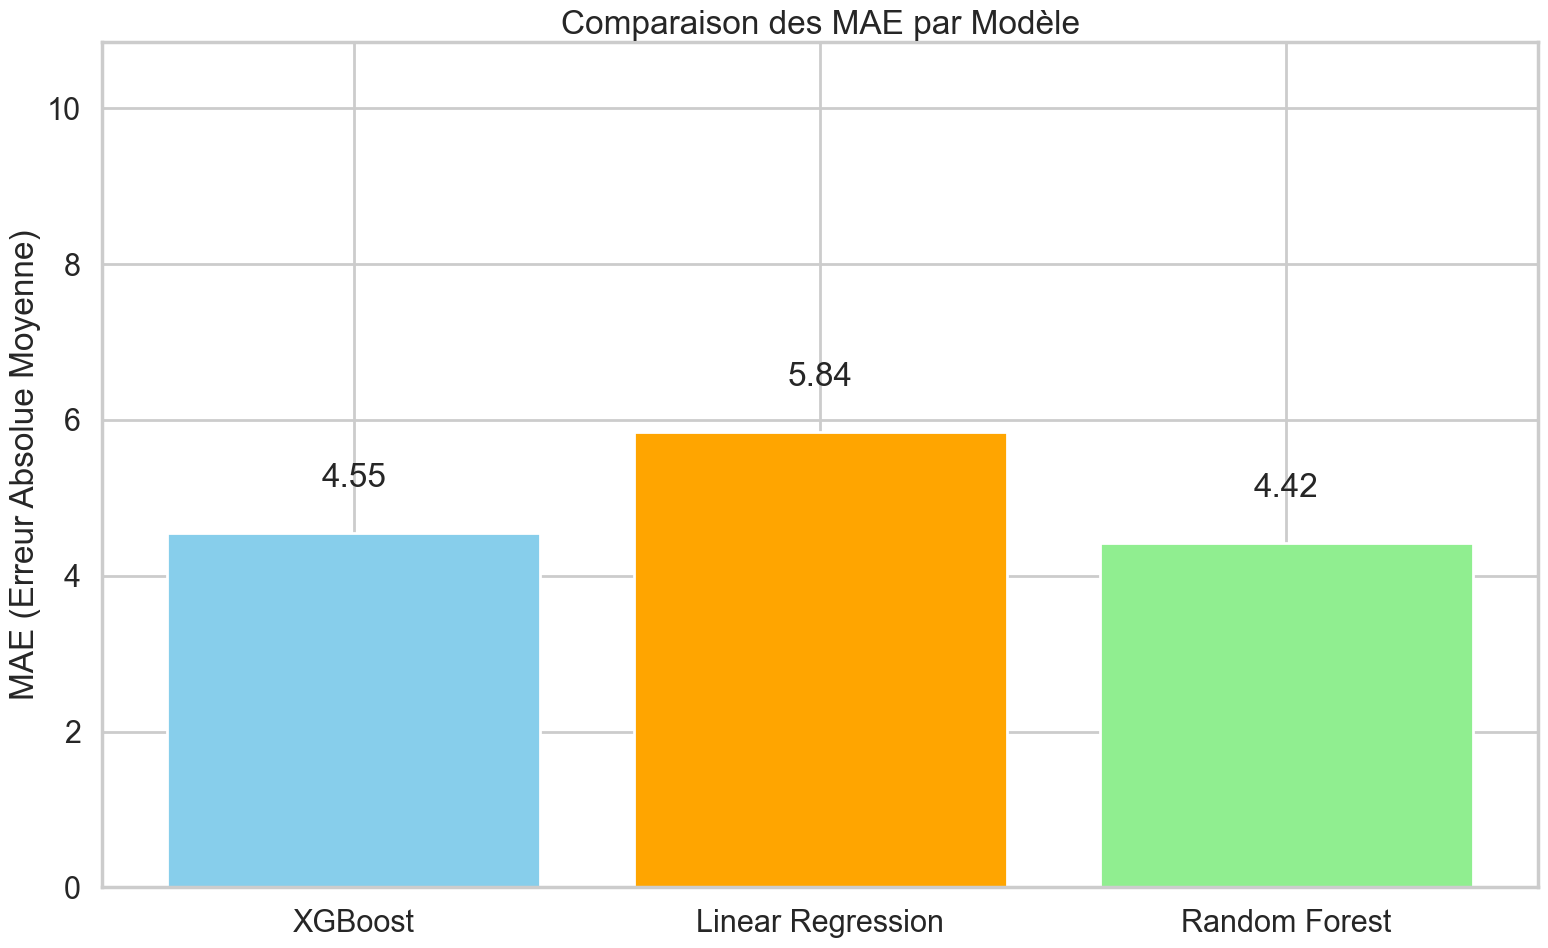

In [285]:
mae_scores = {
    'XGBoost': mae_xgb,
    'Linear Regression': mae_linear,
    'Random Forest': mae_rf
}

# Création du graphique
plt.figure(figsize=(16, 10))
plt.bar(mae_scores.keys(), mae_scores.values(), color=['skyblue', 'orange', 'lightgreen'])
plt.title('Comparaison des MAE par Modèle')
plt.ylabel('MAE (Erreur Absolue Moyenne)')
plt.ylim(0, max(mae_scores.values()) + 5)

# Affichage des valeurs sur les barres
for i, (model, score) in enumerate(mae_scores.items()):
    plt.text(i, score + 0.5, f'{score:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

On observe que le random forest à de meilleurs résultat que les autres en terme de MAE mais aussi en terme d'accurancy à 94%

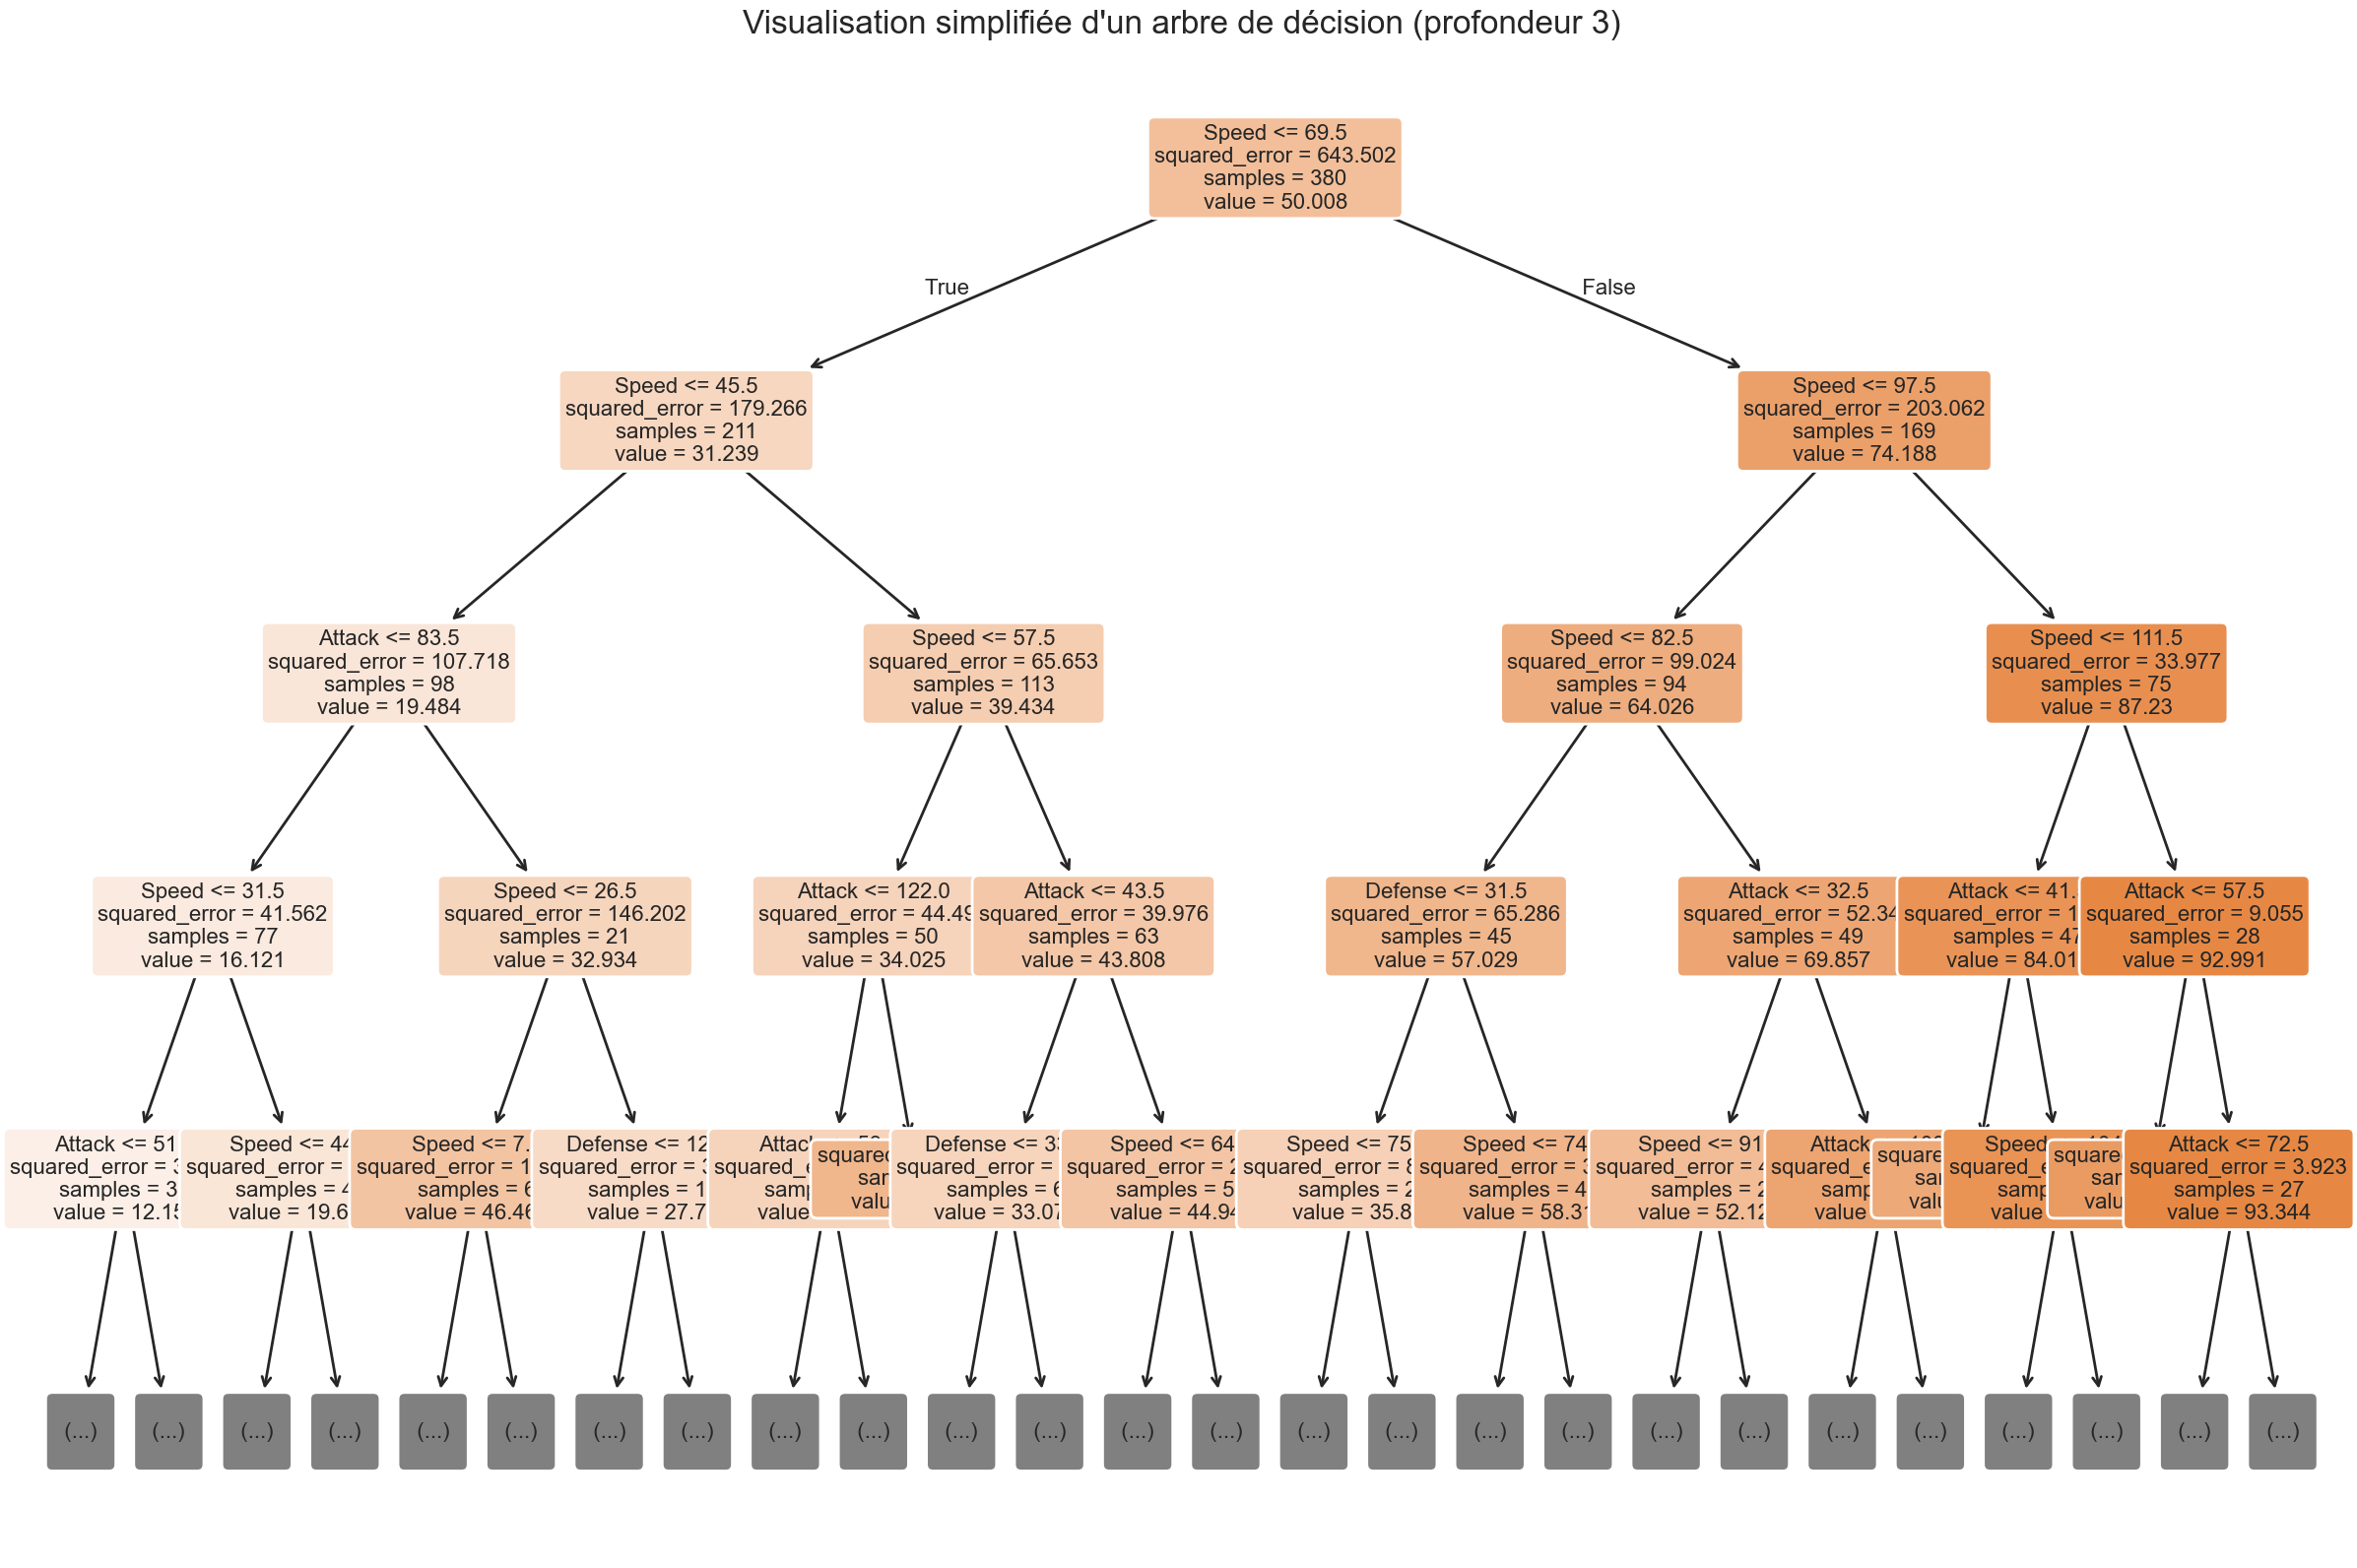

In [ ]:

from sklearn.tree import plot_tree
plt.figure(figsize=(30, 20))
plot_tree(rf_model.estimators_[0], 
          feature_names=X.columns, 
          filled=True, 
          rounded=True, 
          max_depth=4,  # Limite la profondeur pour lisibilité
          fontsize=16)
plt.title('Visualisation simplifiée d\'un arbre de décision (profondeur 4)')
plt.show()